In [1]:
import os

import numpy as np
import pandas as pd
from root_pandas import read_root, to_root

import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import xgboost as xgb

from itertools import islice

from tqdm import tqdm

import ROOT

from scripts.data_preparation import get_single_tagging_particles, concat_df_chunks

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14

# Read in Data from `/net/storage`
The dataset is huge and does not fit into RAM easily. Thats why in the first place only the essential B-branches are activated. The full 2012 data for $B^+\to J\!/\psi K^+$ contains 54M tagging particle candidates after Selection S1 and S2 which will be held completely in RAM (about 10G physical memory)!

In [3]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
filenames = [
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MD_sweighted_kheinick.root',
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MU_sweighted_kheinick.root',
]
chunksize = 5000

In [4]:
# just define some keyword arguments for read_root in a separate dict
data_kwargs = dict(
    key='DecayTree',  # the tree name
    columns=['B_OS_Muon*',  # all branches that should be read
             'B_ID',
             'B_PT',
             'SigYield_sw'
            ],
    chunksize=chunksize,  # this will create a generator, yielding subsets with 'chunksize' of the data
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',  # a ROOT where selection, does not work with array-variables
    flatten=True  # will flatten the data in the dimension of the first given column
)

In [5]:
# still have to use plain ROOT to get the number of entries...
n_entries = 0
for fn in filenames:
    f = ROOT.TFile(fn)
    t = f.Get('DecayTree')
    n_entries += t.GetEntries()

In [6]:
# This will read chunks of the data inside a list comprehension and then concat those to a big dataframe
# note that tqdm is just some boilerplate to generate a progressbar
# df = pd.concat([df for df in tqdm(read_root(filenames, **data_kwargs), total=n_entries/chunksize)])

# only use the first 10 chunks to speed up read process and reduce RAM pressure for development
df = pd.concat([df for df in tqdm(islice(read_root(filenames, **data_kwargs), 10), total=10)])

100%|██████████| 10/10 [00:18<00:00,  1.78s/it]


We have 54M tagging particle candidates and 34 feature columns:

In [7]:
df.shape

(3202977, 34)

## Cleanup and Target definition
The dataset might contain some infs and NANs with which the classifiers might have problems. We'll just drop them or replace them by some default values.

(The current dataset contains values of an older version of IPPUs which resultet in infs)

In [8]:
df.replace(np.inf, 10000, inplace=True)
df.dropna(inplace=True)

After cleaning up, add the target that should be predicted. Here we use whether the charge of the tagging particle candidate matches the charge of the signal candidate. The MVA will therefore predict a "correct tag estimate".

In [9]:
df['target'] = np.sign(df.B_ID) == np.sign(df.B_OS_Muon_ID)

In [21]:
# use abs(phiDistance)
df.B_OS_Muon_phiDistance = np.abs(df.B_OS_Muon_phiDistance)

# Define the classic muon tagger features and prepare the training dataset

In [10]:
classic_MVA_features = [
    'B_OS_Muon_countTracks',  # aka mult
    'B_OS_Muon_P',
    'B_OS_Muon_PT',
    'B_PT',
    'B_OS_Muon_ABS_RecVertexIP',  # aka IPs
    'B_OS_Muon_TRCHI2DOF',
    'B_OS_Muon_PROBNNmu',
    'B_OS_Muon_TRGHP',
    'B_OS_Muon_IPPUs',
]

In [11]:
# scale the data to make it usable for TMVA aswell
# /= 1000 somehow kills the kernel. Maybe a bug in pandas?
df.B_OS_Muon_P *= 0.001
df.B_OS_Muon_PT *= 0.001
df.B_PT *= 0.001

# Apply Muon Selections

In [28]:
# define all the classic selections for muon tagger here for a query
queries = [
    'B_OS_Muon_P > 0',
    'B_OS_Muon_PT > 0.5',
    'B_OS_Muon_IsSignalDaughter == 0',
    'B_OS_Muon_phiDistance > 0.005',
    'B_OS_Muon_MuonPIDIsMuon == 1',
    'B_OS_Muon_TRCHI2DOF < 3',
    'B_OS_Muon_RecVertexIP > 0',
    'B_OS_Muon_TRGHP < 0.4',
    'B_OS_Muon_PROBNNmu > 0.35',
    'B_OS_Muon_PROBNNpi < 0.8',
    'B_OS_Muon_PROBNNe < 0.8',
    'B_OS_Muon_PROBNNk < 0.8',
    'B_OS_Muon_PROBNNp < 0.8',
#    'SigYield_sw > 0'
]

In [101]:
# apply query
selected_data = df.query(' and '.join(queries))

labels = selected_data.target

selection_efficiency = len(selected_data) / len(np.unique(df.B_PT))
print('Efficiency {:2.3f}%'.format(100 * selection_efficiency))

Efficiency 17.992%


In [29]:
selected_data.shape

(8025, 35)

# And order by transverse momentum

In [92]:
# groupby will group the rows by given column (in this case B_PT is used as there was now event id information)
# .agg(np.argmax) will then call argmax in every group, which will result in the indices of the element with maximum
# transverse momentum
max_pt_data = selected_data.loc[selected_data.groupby('B_PT')['B_OS_Muon_PT'].agg(np.argmax).astype('int')]

# store labels separately
labels = max_pt_data.target

# calculate efficiency of this selection
max_pt_efficiency = len(max_pt_data) / len(np.unique(df.B_PT))
print('Efficiency {:2.3f}%'.format(100 * max_pt_efficiency))

Efficiency 6.728%


### Print the features after selection

  9%|▊         | 3/35 [00:01<00:19,  1.66it/s]


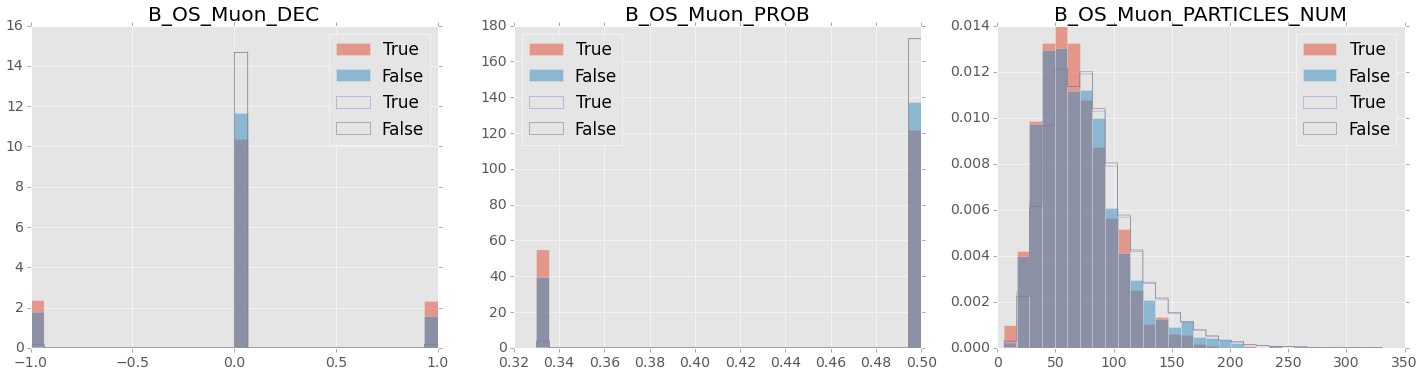

In [113]:
ncols = 3
nrows = np.ceil(len(selected_data.columns)/ncols)
plt.figure(figsize=(20, nrows * 5))
for i, f in tqdm(enumerate(selected_data.columns), total=len(selected_data.columns)):
    plt.subplot(nrows, ncols, i+1)
    _, bins = np.histogram(df[f], 30)
    max_pt_data[max_pt_data.target==True][f].hist(bins=bins, label='True', alpha=0.5, normed=True)
    max_pt_data[max_pt_data.target==False][f].hist(bins=bins, label='False', alpha=0.5, normed=True)
    df[df.target==True][f].hist(bins=bins, label='True', histtype='step', normed=True)
    df[df.target==False][f].hist(bins=bins, label='False', histtype='step', normed=True)
    plt.title(f[:24])
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Train some Classifiers

In [93]:
def avg_dilution(labels, prediction, threshold=0.5):
    """ Return average dilution
    """
    # list of wrongly tagged rows
    mistagged = labels != (prediction > threshold)
    omega = np.sum(mistags) / len(labels)
    return 1 - 2*omega

In [94]:
# split dataset and labels into random subsets, 70% train data, 30% test data
train_data, test_data, train_labels, test_labels = train_test_split(max_pt_data, labels, test_size=0.3)

In [102]:
# define a XGBoost Classifier
xgboost_model = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.01, seed=1)

In [103]:
# train the classifier
xgboost_model.fit(train_data[classic_MVA_features], train_labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=1)

In [104]:
# receive probability predictions for being "TRUE" (tag is correct)
probas = xgboost_model.predict_proba(test_data[classic_MVA_features])[:,1]
preds = xgboost_model.predict(test_data[classic_MVA_features])  # essentially just probas > 0.5

# calculate roc_auc_scored
score = roc_auc_score(test_labels, probas)

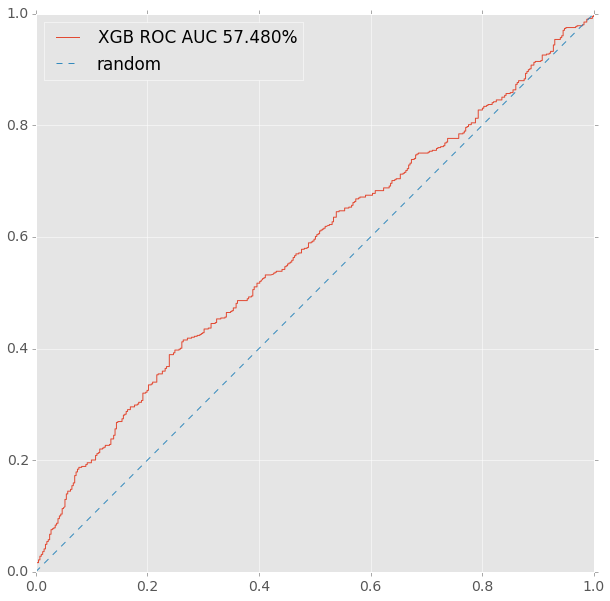

In [105]:
plt.figure(figsize=(10, 10))
plt.plot(*roc_curve(test_labels, probas)[:2], label='XGB ROC AUC {:2.3f}%'.format(score * 100))
plt.plot([0, 1], '--', label='random')
plt.legend(loc='best')
plt.show()

In [106]:
print('eps_eff = {:2.3f}%'.format(100 * max_pt_efficiency * avg_dilution(test_labels, probas)**2))

eps_eff = 0.165%


In [107]:
from IPython.display import FileLink
b = xgboost_model.booster()
b.save_model('trained_model.xgb')
# TaggingClassifer can now use this model via `tagging_classifier.ClassifierFilename = 'trained_model.xgb'`
FileLink('trained_model.xgb', result_html_prefix='Download model ')

/home/kheinicke/repos/fttrainer/trained_model.xgb